# Simple Far Field Grating Simulation with FFT reconstruction

In [1]:
import idi.reconstruction as recon
import idi.simulation as sim
import idi.util as util
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
from tqdm.notebook import tqdm

## Settings

In [2]:
Ndet = 1024  # pixel
detz = 100 * 1e4  # um
pixelsize = 100  # um
E = 10000  # eV
Nimg = 100
Nphotons = 1e4 * 10
Natoms = 1e7 / 1000  # speed simulation up for demo
modes = 4
rebin = 2

## Simulation

In [3]:
print("preparing")


simobject = sim.simobj.grating(E, Natoms, 0.01, 0.03, fwhm=[0.2, 0.2, 0.2], rho=[2, 2, 10], rholine=20)
simobject.rndPhase = True
simgen = sim.cuda.simulate_gen(simobject, Ndet * rebin, pixelsize / rebin, detz, simobject.k, settings='single', maximg=Nimg * modes)


@util.asgen
def photons(img, Nphotons, rebin):
    img = np.abs(img) ** 2
    img = util.rebin(img, [len(img), rebin, rebin], 'sum')
    return np.squeeze(sim.randomphotons(img, Nphotons) * (np.prod(img.shape) / Nphotons))


corr = recon.cusimple.corr
norm = corr(np.ones((Ndet, Ndet)))
norm[norm < 10] = np.nan
norm = 1 / norm

preparing


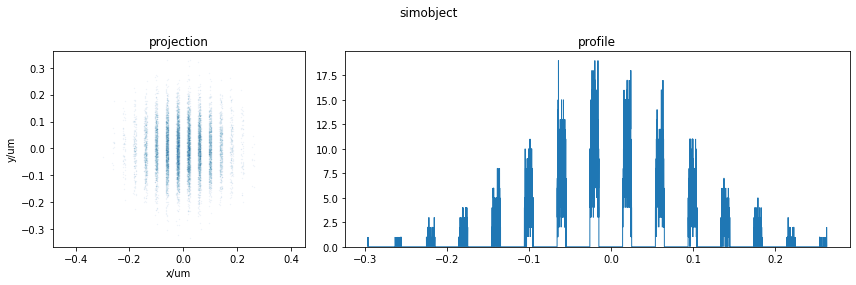

In [4]:
pos = simobject.get2()[0]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 2]})
ax1.axis('equal')
ax1.scatter(pos[:10000, 0], pos[:10000, 1], alpha=0.1, s=0.1)
ax1.set_title('projection')
ax1.set_xlabel('x/um')
ax1.set_ylabel('y/um')

_ = ax2.hist(pos[:, 0], bins=10000, histtype='step')
ax2.set_title('profile')

plt.suptitle('simobject')
plt.tight_layout()
plt.show()

In [5]:
print('simulating')
result = util.accumulator()
for p in tqdm(photons(util.group(simgen, modes), Nphotons, rebin), total=Nimg):
    result.add((corr(p) * norm) - 1)
print('done')

simulating



done


## Plot result

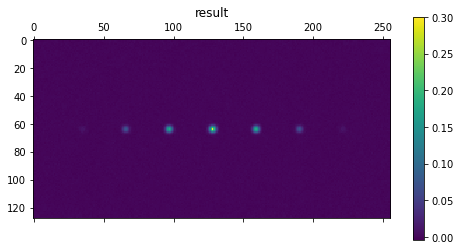

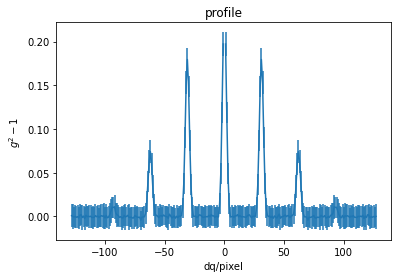

In [7]:
mean = np.array(util.centered_part(result.mean, (256, 128)))
std = np.array(util.centered_part(result.std, (256, 128)))

plt.matshow(mean.T, vmax=0.3)
plt.title('result')
plt.colorbar()
plt.show()

mean[mean.shape[0] // 2, mean.shape[1] // 2] = np.nan
m = mean[:, mean.shape[1] // 2]
s = std[:, std.shape[1] // 2]
plt.errorbar(
    np.arange(-len(m) / 2, len(m) / 2), m, yerr=s,
)
plt.xlabel('dq/pixel')
plt.ylabel('$g^2-1$')
plt.title('profile');